# Tree-Based Intelligent Intrusion Detection System in Internet of Vehicles
This is the code for the paper entitled "[**Tree-Based Intelligent Intrusion Detection System in Internet of Vehicles**](https://arxiv.org/pdf/1910.08635.pdf)" published in IEEE GlobeCom 2019.  
Authors: Li Yang (liyanghart@gmail.com), Abdallah Moubayed, Ismail Hamieh, and Abdallah Shami  
Organization: The Optimized Computing and Communications (OC2) Lab, ECE Department, Western University

If you find this repository useful in your research, please cite:  
L. Yang, A. Moubayed, I. Hamieh and A. Shami, "Tree-Based Intelligent Intrusion Detection System in Internet of Vehicles," 2019 IEEE Global Communications Conference (GLOBECOM), 2019, pp. 1-6, doi: 10.1109/GLOBECOM38437.2019.9013892.  

In [1]:
import warnings
warnings.filterwarnings("ignore")

In [208]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report,confusion_matrix,accuracy_score,precision_recall_fscore_support
from sklearn.metrics import f1_score
from sklearn.ensemble import RandomForestClassifier,ExtraTreesClassifier
from sklearn.tree import DecisionTreeClassifier
import xgboost as xgb
from xgboost import plot_importance

## Read the sampled CICIDS2017 dataset
The CICIDS2017 dataset is publicly available at: https://www.unb.ca/cic/datasets/ids-2017.html  
Due to the large size of this dataset, the sampled subsets of CICIDS2017 is used. The subsets are in the "data" folder.  
If you want to use this code on other datasets (e.g., CAN-intrusion dataset), just change the dataset name and follow the same steps. The models in this code are generic models that can be used in any intrusion detection/network traffic datasets.

### Preprocessing (normalization and padding values)

In [209]:
df1 = pd.read_csv('/content/CICIDS2017_sample (1).csv')

In [210]:
df = pd.read_csv('/content/CICIDS2017_sample (1).csv')

In [211]:
df

,Flow Duration,Total Fwd Packets,Total Backward Packets,Total Length of Fwd Packets,Total Length of Bwd Packets,Fwd Packet Length Max,Fwd Packet Length Min,Fwd Packet Length Mean,Fwd Packet Length Std,Bwd Packet Length Max,...,min_seg_size_forward,Active Mean,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min,Label
0,4,2,0,37,0,31,6,18.500000,17.677670,0,...,20,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
1,142377,46,62,1325,105855,570,0,28.804348,111.407285,4344,...,20,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
2,118873,23,28,1169,45025,570,0,50.826087,156.137367,2896,...,32,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
3,143577,43,55,1301,107289,570,0,30.255814,115.178969,4344,...,20,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
4,143745,49,59,1331,110185,570,0,27.163265,108.067176,4344,...,20,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
56656,234,2,2,64,232,32,32,32.000000,0.000000,116,...,32,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
56657,133288,2,2,94,482,47,47,47.000000,0.000000,241,...,32,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
56658,11507694,5,4,450,3525,450,0,90.000000,201.246118,3525,...,32,893.0,0.0,893,893,6503640.0,0.0,6503640,6503640,DoS
56659,11507707,8,6,416,11632,416,0,52.000000,147.078211,5792,...,32,897.0,0.0,897,897,6503122.0,0.0,6503122,6503122,DoS


In [212]:
# Min-max normalization
numeric_features = df.dtypes[df.dtypes != 'object'].index
df[numeric_features] = df[numeric_features].apply(
    lambda x: (x - x.min()) / (x.max()-x.min()))
# Fill empty values by 0
df = df.fillna(0)

### split train set and test set

In [213]:
labelencoder = LabelEncoder()
df.iloc[:, -1] = labelencoder.fit_transform(df.iloc[:, -1])
X = df.drop(['Label'],axis=1).values
y = df.iloc[:, -1].values.reshape(-1,1)
y=np.ravel(y)

In [214]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 56661 entries, 0 to 56660
Data columns (total 78 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   Flow Duration                56661 non-null  float64
 1   Total Fwd Packets            56661 non-null  float64
 2   Total Backward Packets       56661 non-null  float64
 3   Total Length of Fwd Packets  56661 non-null  float64
 4   Total Length of Bwd Packets  56661 non-null  float64
 5   Fwd Packet Length Max        56661 non-null  float64
 6   Fwd Packet Length Min        56661 non-null  float64
 7   Fwd Packet Length Mean       56661 non-null  float64
 8   Fwd Packet Length Std        56661 non-null  float64
 9   Bwd Packet Length Max        56661 non-null  float64
 10  Bwd Packet Length Min        56661 non-null  float64
 11  Bwd Packet Length Mean       56661 non-null  float64
 12  Bwd Packet Length Std        56661 non-null  float64
 13  Flow Bytes/s    

In [215]:
X_train, X_test, y_train, y_test = train_test_split(X,y, train_size = 0.8, test_size = 0.2, random_state = 0,stratify = y)

In [216]:
X_train.shape

(45328, 77)

In [217]:
pd.Series(y_train).value_counts()

0    18184
3    15228
5     6357
2     2213
6     1744
1     1573
4       29
dtype: int64

### Oversampling by SMOTE





In [218]:
from imblearn.over_sampling import SMOTE
smote=SMOTE(n_jobs=-1,sampling_strategy={4:1500}) # Create 1500 samples for the minority class "4"

In [219]:
X_train, y_train = smote.fit_resample(X_train, y_train)

In [220]:
pd.Series(y_train).value_counts()

0    18184
3    15228
5     6357
2     2213
6     1744
1     1573
4     1500
dtype: int64

## Machine learning model training

### Training four base learners: decision tree, random forest, extra trees, XGBoost

Accuracy of DT: 0.995764581311215
Precision of DT: 0.9958703639084684
Recall of DT: 0.995764581311215
F1-score of DT: 0.9957994130825865
              precision    recall  f1-score   support

           0       1.00      0.99      1.00      4547
           1       0.99      0.98      0.98       393
           2       0.99      1.00      1.00       554
           3       1.00      1.00      1.00      3807
           4       0.60      0.86      0.71         7
           5       1.00      1.00      1.00      1589
           6       0.99      0.99      0.99       436

    accuracy                           1.00     11333
   macro avg       0.94      0.97      0.95     11333
weighted avg       1.00      1.00      1.00     11333



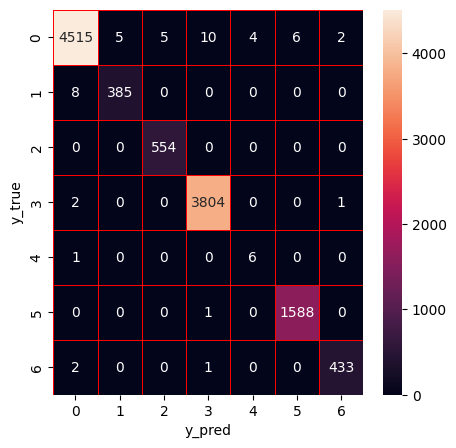

In [221]:
# Decision tree training and prediction
dt = DecisionTreeClassifier(random_state = 0)
dt.fit(X_train,y_train)
dt_score=dt.score(X_test,y_test)
y_predict=dt.predict(X_test)
y_true=y_test
print('Accuracy of DT: '+ str(dt_score))
precision,recall,fscore,none= precision_recall_fscore_support(y_true, y_predict, average='weighted')
print('Precision of DT: '+(str(precision)))
print('Recall of DT: '+(str(recall)))
print('F1-score of DT: '+(str(fscore)))
print(classification_report(y_true,y_predict))
cm=confusion_matrix(y_true,y_predict)
f,ax=plt.subplots(figsize=(5,5))
sns.heatmap(cm,annot=True,linewidth=0.5,linecolor="red",fmt=".0f",ax=ax)
plt.xlabel("y_pred")
plt.ylabel("y_true")
plt.show()

In [222]:
dt_train=dt.predict(X_train)
dt_test=dt.predict(X_test)

Accuracy of RF: 0.9954116297538163
Precision of RF: 0.9954396998156001
Recall of RF: 0.9954116297538163
F1-score of RF: 0.995401995713903
              precision    recall  f1-score   support

           0       1.00      0.99      0.99      4547
           1       0.96      0.98      0.97       393
           2       1.00      1.00      1.00       554
           3       1.00      1.00      1.00      3807
           4       1.00      0.71      0.83         7
           5       1.00      1.00      1.00      1589
           6       1.00      0.98      0.99       436

    accuracy                           1.00     11333
   macro avg       0.99      0.95      0.97     11333
weighted avg       1.00      1.00      1.00     11333



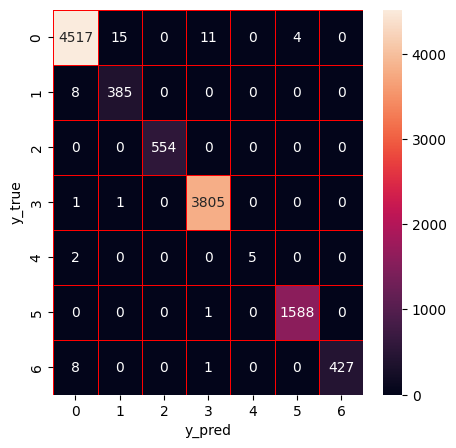

In [223]:
# Random Forest training and prediction
rf = RandomForestClassifier(random_state = 0)
rf.fit(X_train,y_train)
rf_score=rf.score(X_test,y_test)
y_predict=rf.predict(X_test)
y_true=y_test
print('Accuracy of RF: '+ str(rf_score))
precision,recall,fscore,none= precision_recall_fscore_support(y_true, y_predict, average='weighted')
print('Precision of RF: '+(str(precision)))
print('Recall of RF: '+(str(recall)))
print('F1-score of RF: '+(str(fscore)))
print(classification_report(y_true,y_predict))
cm=confusion_matrix(y_true,y_predict)
f,ax=plt.subplots(figsize=(5,5))
sns.heatmap(cm,annot=True,linewidth=0.5,linecolor="red",fmt=".0f",ax=ax)
plt.xlabel("y_pred")
plt.ylabel("y_true")
plt.show()

In [224]:
rf_train=rf.predict(X_train)
rf_test=rf.predict(X_test)

Accuracy of ET: 0.992676255183976
Precision of ET: 0.9926875778879892
Recall of ET: 0.992676255183976
F1-score of ET: 0.9926591858580645
              precision    recall  f1-score   support

           0       0.99      0.99      0.99      4547
           1       0.96      0.97      0.96       393
           2       0.99      1.00      0.99       554
           3       0.99      1.00      1.00      3807
           4       1.00      0.71      0.83         7
           5       1.00      1.00      1.00      1589
           6       0.99      0.97      0.98       436

    accuracy                           0.99     11333
   macro avg       0.99      0.95      0.97     11333
weighted avg       0.99      0.99      0.99     11333



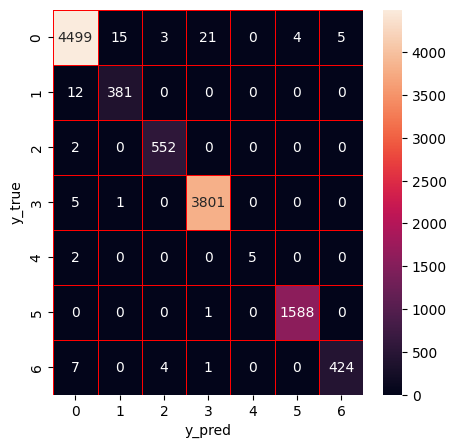

In [225]:
# Extra trees training and prediction
et = ExtraTreesClassifier(random_state = 0)
et.fit(X_train,y_train)
et_score=et.score(X_test,y_test)
y_predict=et.predict(X_test)
y_true=y_test
print('Accuracy of ET: '+ str(et_score))
precision,recall,fscore,none= precision_recall_fscore_support(y_true, y_predict, average='weighted')
print('Precision of ET: '+(str(precision)))
print('Recall of ET: '+(str(recall)))
print('F1-score of ET: '+(str(fscore)))
print(classification_report(y_true,y_predict))
cm=confusion_matrix(y_true,y_predict)
f,ax=plt.subplots(figsize=(5,5))
sns.heatmap(cm,annot=True,linewidth=0.5,linecolor="red",fmt=".0f",ax=ax)
plt.xlabel("y_pred")
plt.ylabel("y_true")
plt.show()

In [226]:
et_train=et.predict(X_train)
et_test=et.predict(X_test)

Accuracy of XGBoost: 0.9937351098561722
Precision of XGBoost: 0.9937300111222847
Recall of XGBoost: 0.9937351098561722
F1-score of XGBoost: 0.9937165377181066
              precision    recall  f1-score   support

           0       0.99      0.99      0.99      4547
           1       0.99      0.97      0.98       393
           2       1.00      0.99      0.99       554
           3       0.99      1.00      1.00      3807
           4       0.83      0.71      0.77         7
           5       1.00      1.00      1.00      1589
           6       1.00      0.98      0.99       436

    accuracy                           0.99     11333
   macro avg       0.97      0.95      0.96     11333
weighted avg       0.99      0.99      0.99     11333



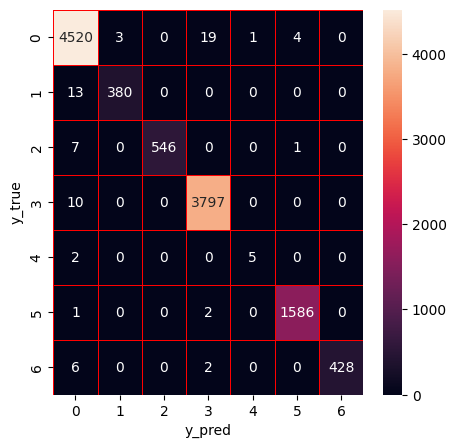

In [227]:
# XGboost training and prediction
xg = xgb.XGBClassifier(n_estimators = 10)
xg.fit(X_train,y_train)
xg_score=xg.score(X_test,y_test)
y_predict=xg.predict(X_test)
y_true=y_test
print('Accuracy of XGBoost: '+ str(xg_score))
precision,recall,fscore,none= precision_recall_fscore_support(y_true, y_predict, average='weighted')
print('Precision of XGBoost: '+(str(precision)))
print('Recall of XGBoost: '+(str(recall)))
print('F1-score of XGBoost: '+(str(fscore)))
print(classification_report(y_true,y_predict))
cm=confusion_matrix(y_true,y_predict)
f,ax=plt.subplots(figsize=(5,5))
sns.heatmap(cm,annot=True,linewidth=0.5,linecolor="red",fmt=".0f",ax=ax)
plt.xlabel("y_pred")
plt.ylabel("y_true")
plt.show()

In [228]:
xg_train=xg.predict(X_train)
xg_test=xg.predict(X_test)

### Stacking model construction (ensemble for 4 base learners)


In [229]:
# Use the outputs of 4 base models to construct a new ensemble model
base_predictions_train = pd.DataFrame( {
    'DecisionTree': dt_train.ravel(),
        'RandomForest': rf_train.ravel(),
     'ExtraTrees': et_train.ravel(),
     'XgBoost': xg_train.ravel(),
    })
base_predictions_train.head(5)

,DecisionTree,RandomForest,ExtraTrees,XgBoost
0,5,5,5,5
1,3,3,3,3
2,5,5,5,5
3,3,3,3,3
4,2,2,2,2


In [230]:
dt_train=dt_train.reshape(-1, 1)
et_train=et_train.reshape(-1, 1)
rf_train=rf_train.reshape(-1, 1)
xg_train=xg_train.reshape(-1, 1)
dt_test=dt_test.reshape(-1, 1)
et_test=et_test.reshape(-1, 1)
rf_test=rf_test.reshape(-1, 1)
xg_test=xg_test.reshape(-1, 1)

In [231]:
x_train = np.concatenate(( dt_train, et_train, rf_train, xg_train), axis=1)
x_test = np.concatenate(( dt_test, et_test, rf_test, xg_test), axis=1)

In [232]:
x_train

array([[5, 5, 5, 5],
       [3, 3, 3, 3],
       [5, 5, 5, 5],
       ...,
       [4, 4, 4, 4],
       [4, 4, 4, 4],
       [4, 4, 4, 4]])

In [233]:
stk = xgb.XGBClassifier().fit(x_train, y_train)

Accuracy of Stacking: 0.9956763434218654
Precision of Stacking: 0.9956797642373375
Recall of Stacking: 0.9956763434218654
F1-score of Stacking: 0.9956585173545193
              precision    recall  f1-score   support

           0       1.00      0.99      1.00      4547
           1       0.99      0.98      0.98       393
           2       0.99      1.00      1.00       554
           3       1.00      1.00      1.00      3807
           4       1.00      0.71      0.83         7
           5       1.00      1.00      1.00      1589
           6       0.99      0.99      0.99       436

    accuracy                           1.00     11333
   macro avg       0.99      0.95      0.97     11333
weighted avg       1.00      1.00      1.00     11333



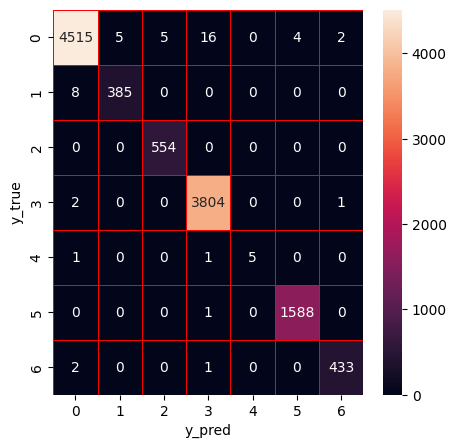

In [234]:
y_predict=stk.predict(x_test)
y_true=y_test
stk_score=accuracy_score(y_true,y_predict)
print('Accuracy of Stacking: '+ str(stk_score))
precision,recall,fscore,none= precision_recall_fscore_support(y_true, y_predict, average='weighted')
print('Precision of Stacking: '+(str(precision)))
print('Recall of Stacking: '+(str(recall)))
print('F1-score of Stacking: '+(str(fscore)))
print(classification_report(y_true,y_predict))
cm=confusion_matrix(y_true,y_predict)
f,ax=plt.subplots(figsize=(5,5))
sns.heatmap(cm,annot=True,linewidth=0.5,linecolor="red",fmt=".0f",ax=ax)
plt.xlabel("y_pred")
plt.ylabel("y_true")
plt.show()

## Feature Selection

### Feature importance

In [235]:
# Save the feature importance lists generated by four tree-based algorithms
dt_feature = dt.feature_importances_
rf_feature = rf.feature_importances_
et_feature = et.feature_importances_
xgb_feature = xg.feature_importances_

In [236]:
# calculate the average importance value of each feature
avg_feature = (dt_feature + rf_feature + et_feature + xgb_feature)/4

In [237]:
feature=(df.drop(['Label'],axis=1)).columns.values
print ("Features sorted by their score:")
print (sorted(zip(map(lambda x: round(x, 4), avg_feature), feature), reverse=True))

Features sorted by their score:
[(0.1181, 'Bwd Packet Length Std'), (0.0794, 'Bwd Packet Length Min'), (0.0669, 'Average Packet Size'), (0.0504, 'Init_Win_bytes_backward'), (0.0431, 'Init_Win_bytes_forward'), (0.0389, 'PSH Flag Count'), (0.0382, 'Bwd Packets/s'), (0.0344, 'Avg Bwd Segment Size'), (0.0298, 'Packet Length Std'), (0.0284, 'Bwd Packet Length Mean'), (0.0244, 'Fwd Header Length'), (0.024, 'Packet Length Mean'), (0.0234, 'Bwd Header Length'), (0.0173, 'min_seg_size_forward'), (0.017, 'act_data_pkt_fwd'), (0.017, 'Bwd Packet Length Max'), (0.0164, 'Max Packet Length'), (0.0157, 'Subflow Bwd Packets'), (0.0145, 'Total Length of Fwd Packets'), (0.0143, 'Packet Length Variance'), (0.0143, 'ACK Flag Count'), (0.0127, 'Fwd PSH Flags'), (0.012, 'Idle Max'), (0.0117, 'Fwd Header Length.1'), (0.0111, 'Fwd IAT Max'), (0.0109, 'Fwd Packet Length Mean'), (0.0107, 'Total Fwd Packets'), (0.0102, 'Total Length of Bwd Packets'), (0.0101, 'Min Packet Length'), (0.0092, 'Fwd IAT Mean'), (0.00

In [238]:
f_list = sorted(zip(map(lambda x: round(x, 4), avg_feature), feature), reverse=True)

In [239]:
f_list

[(0.1181, 'Bwd Packet Length Std'),
 (0.0794, 'Bwd Packet Length Min'),
 (0.0669, 'Average Packet Size'),
 (0.0504, 'Init_Win_bytes_backward'),
 (0.0431, 'Init_Win_bytes_forward'),
 (0.0389, 'PSH Flag Count'),
 (0.0382, 'Bwd Packets/s'),
 (0.0344, 'Avg Bwd Segment Size'),
 (0.0298, 'Packet Length Std'),
 (0.0284, 'Bwd Packet Length Mean'),
 (0.0244, 'Fwd Header Length'),
 (0.024, 'Packet Length Mean'),
 (0.0234, 'Bwd Header Length'),
 (0.0173, 'min_seg_size_forward'),
 (0.017, 'act_data_pkt_fwd'),
 (0.017, 'Bwd Packet Length Max'),
 (0.0164, 'Max Packet Length'),
 (0.0157, 'Subflow Bwd Packets'),
 (0.0145, 'Total Length of Fwd Packets'),
 (0.0143, 'Packet Length Variance'),
 (0.0143, 'ACK Flag Count'),
 (0.0127, 'Fwd PSH Flags'),
 (0.012, 'Idle Max'),
 (0.0117, 'Fwd Header Length.1'),
 (0.0111, 'Fwd IAT Max'),
 (0.0109, 'Fwd Packet Length Mean'),
 (0.0107, 'Total Fwd Packets'),
 (0.0102, 'Total Length of Bwd Packets'),
 (0.0101, 'Min Packet Length'),
 (0.0092, 'Fwd IAT Mean'),
 (0.009,

In [240]:
# Select the important features from top-importance to bottom-importance until the accumulated importance reaches 0.9 (out of 1)
Sum = 0
fs = []
for i in range(0, 15):
    Sum = Sum + f_list[i][0]
    fs.append(f_list[i][1])
    if Sum>=0.9:
        break

In [241]:
X_fs = df[fs].values

In [242]:
X_fs

array([[0.00000000e+00, 0.00000000e+00, 1.59005879e-02, ...,
        0.00000000e+00, 3.33333333e-01, 1.66833500e-04],
       [1.26400520e-01, 0.00000000e+00, 4.64113566e-01, ...,
        1.00834211e-02, 3.33333333e-01, 5.00500501e-03],
       [1.34744047e-01, 0.00000000e+00, 4.23593863e-01, ...,
        4.57601037e-03, 5.33333333e-01, 6.67334001e-04],
       ...,
       [2.63280686e-01, 0.00000000e+00, 2.06551755e-01, ...,
        6.88426338e-04, 5.33333333e-01, 1.66833500e-04],
       [3.80157728e-01, 0.00000000e+00, 4.02458578e-01, ...,
        1.01239167e-03, 5.33333333e-01, 1.66833500e-04],
       [6.62803535e-01, 0.00000000e+00, 4.30179254e-01, ...,
        8.50409006e-04, 5.33333333e-01, 1.66833500e-04]])

In [243]:
X_fs.shape

(56661, 15)

In [244]:
X_train, X_test, y_train, y_test = train_test_split(X_fs,y, train_size = 0.8, test_size = 0.2, random_state = 0,stratify = y)

In [245]:
X_train

array([[0.00000000e+00, 4.14364641e-03, 2.33832175e-03, ...,
        1.01239167e-04, 4.00000000e-01, 0.00000000e+00],
       [3.16418904e-01, 0.00000000e+00, 4.28596390e-01, ...,
        1.17437434e-03, 5.33333333e-01, 1.66833500e-04],
       [0.00000000e+00, 4.14364641e-03, 1.40299305e-03, ...,
        1.01239167e-04, 6.66666667e-01, 0.00000000e+00],
       ...,
       [0.00000000e+00, 4.14364641e-03, 4.20897916e-03, ...,
        1.01239167e-04, 3.33333333e-01, 0.00000000e+00],
       [0.00000000e+00, 4.14364641e-03, 2.33832175e-03, ...,
        1.01239167e-04, 4.00000000e-01, 0.00000000e+00],
       [3.40519070e-01, 0.00000000e+00, 4.30646919e-01, ...,
        1.17437434e-03, 3.33333333e-01, 5.00500501e-04]])

In [246]:
X_train.shape

(45328, 15)

In [247]:
pd.Series(y_train).value_counts()

0    18184
3    15228
5     6357
2     2213
6     1744
1     1573
4       29
dtype: int64

### Oversampling by SMOTE

In [248]:
from imblearn.over_sampling import SMOTE
smote=SMOTE(n_jobs=-1,sampling_strategy={4:1500})

In [249]:
X_train, y_train = smote.fit_resample(X_train, y_train)

In [250]:
pd.Series(y_train).value_counts()

0    18184
3    15228
5     6357
2     2213
6     1744
1     1573
4     1500
dtype: int64

## Machine learning model training after feature selection

Accuracy of DT: 0.9935586340774729
Precision of DT: 0.9939119253951915
Recall of DT: 0.9935586340774729
F1-score of DT: 0.9936955534983903
              precision    recall  f1-score   support

           0       1.00      0.99      0.99      4547
           1       0.99      0.99      0.99       393
           2       0.99      1.00      0.99       554
           3       1.00      1.00      1.00      3807
           4       0.33      0.57      0.42         7
           5       1.00      1.00      1.00      1589
           6       0.95      0.99      0.97       436

    accuracy                           0.99     11333
   macro avg       0.89      0.93      0.91     11333
weighted avg       0.99      0.99      0.99     11333



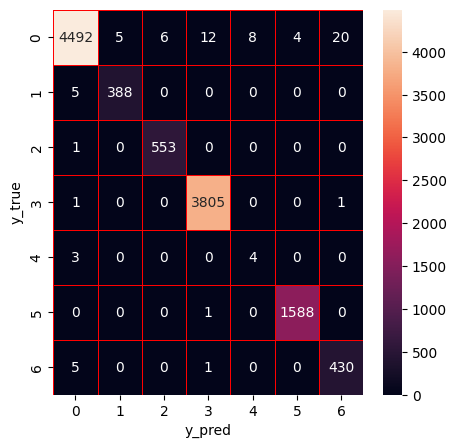

In [251]:
dt = DecisionTreeClassifier(random_state = 0)
dt.fit(X_train,y_train)
dt_score=dt.score(X_test,y_test)
y_predict=dt.predict(X_test)
y_true=y_test
print('Accuracy of DT: '+ str(dt_score))
precision,recall,fscore,none= precision_recall_fscore_support(y_true, y_predict, average='weighted')
print('Precision of DT: '+(str(precision)))
print('Recall of DT: '+(str(recall)))
print('F1-score of DT: '+(str(fscore)))
print(classification_report(y_true,y_predict))
cm=confusion_matrix(y_true,y_predict)
f,ax=plt.subplots(figsize=(5,5))
sns.heatmap(cm,annot=True,linewidth=0.5,linecolor="red",fmt=".0f",ax=ax)
plt.xlabel("y_pred")
plt.ylabel("y_true")
plt.show()

In [252]:
dt_train=dt.predict(X_train)
dt_test=dt.predict(X_test)

Accuracy of RF: 0.995764581311215
Precision of RF: 0.9959178436941877
Recall of RF: 0.995764581311215
F1-score of RF: 0.9958233280613533
              precision    recall  f1-score   support

           0       1.00      0.99      1.00      4547
           1       0.99      0.99      0.99       393
           2       1.00      1.00      1.00       554
           3       1.00      1.00      1.00      3807
           4       0.50      0.71      0.59         7
           5       1.00      1.00      1.00      1589
           6       0.97      0.99      0.98       436

    accuracy                           1.00     11333
   macro avg       0.92      0.95      0.94     11333
weighted avg       1.00      1.00      1.00     11333



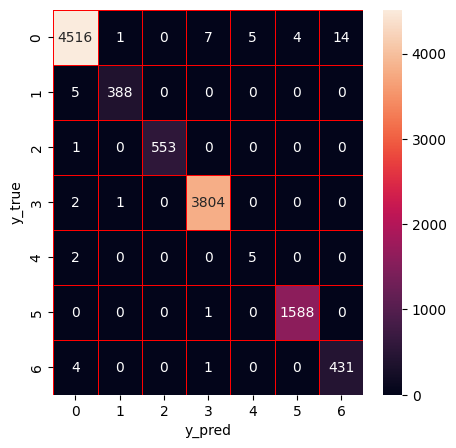

In [253]:
rf = RandomForestClassifier(random_state = 0)
rf.fit(X_train,y_train) # modelin veri üzerinde öğrenmesi fit fonksiyonuyla yapılıyor
rf_score=rf.score(X_test,y_test)
y_predict=rf.predict(X_test)
y_true=y_test
print('Accuracy of RF: '+ str(rf_score))
precision,recall,fscore,none= precision_recall_fscore_support(y_true, y_predict, average='weighted')
print('Precision of RF: '+(str(precision)))
print('Recall of RF: '+(str(recall)))
print('F1-score of RF: '+(str(fscore)))
print(classification_report(y_true,y_predict))
cm=confusion_matrix(y_true,y_predict)
f,ax=plt.subplots(figsize=(5,5))
sns.heatmap(cm,annot=True,linewidth=0.5,linecolor="red",fmt=".0f",ax=ax)
plt.xlabel("y_pred")
plt.ylabel("y_true")
plt.show()

In [254]:
rf_train=rf.predict(X_train)
rf_test=rf.predict(X_test)

Accuracy of ET: 0.995235153975117
Precision of ET: 0.9954024449202317
Recall of ET: 0.995235153975117
F1-score of ET: 0.9952960613490919
              precision    recall  f1-score   support

           0       1.00      0.99      0.99      4547
           1       0.98      0.99      0.99       393
           2       1.00      1.00      1.00       554
           3       1.00      1.00      1.00      3807
           4       0.50      0.71      0.59         7
           5       1.00      1.00      1.00      1589
           6       0.97      0.99      0.98       436

    accuracy                           1.00     11333
   macro avg       0.92      0.96      0.93     11333
weighted avg       1.00      1.00      1.00     11333



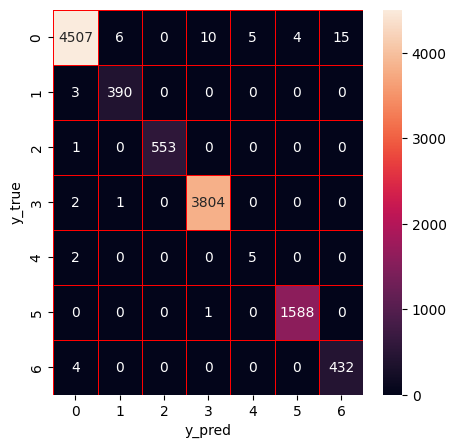

In [255]:
et = ExtraTreesClassifier(random_state = 0)
et.fit(X_train,y_train)
et_score=et.score(X_test,y_test)
y_predict=et.predict(X_test)
y_true=y_test
print('Accuracy of ET: '+ str(et_score))
precision,recall,fscore,none= precision_recall_fscore_support(y_true, y_predict, average='weighted')
print('Precision of ET: '+(str(precision)))
print('Recall of ET: '+(str(recall)))
print('F1-score of ET: '+(str(fscore)))
print(classification_report(y_true,y_predict))
cm=confusion_matrix(y_true,y_predict)
f,ax=plt.subplots(figsize=(5,5))
sns.heatmap(cm,annot=True,linewidth=0.5,linecolor="red",fmt=".0f",ax=ax)
plt.xlabel("y_pred")
plt.ylabel("y_true")
plt.show()

In [256]:
et_train=et.predict(X_train)
et_test=et.predict(X_test)

Accuracy of XGBoost: 0.9910879731756816
Precision of XGBoost: 0.9911368665716496
Recall of XGBoost: 0.9910879731756816
F1-score of XGBoost: 0.9911071004981257
              precision    recall  f1-score   support

           0       0.99      0.99      0.99      4547
           1       0.98      0.98      0.98       393
           2       1.00      0.99      1.00       554
           3       0.99      0.99      0.99      3807
           4       0.62      0.71      0.67         7
           5       1.00      1.00      1.00      1589
           6       0.97      0.98      0.97       436

    accuracy                           0.99     11333
   macro avg       0.94      0.95      0.94     11333
weighted avg       0.99      0.99      0.99     11333



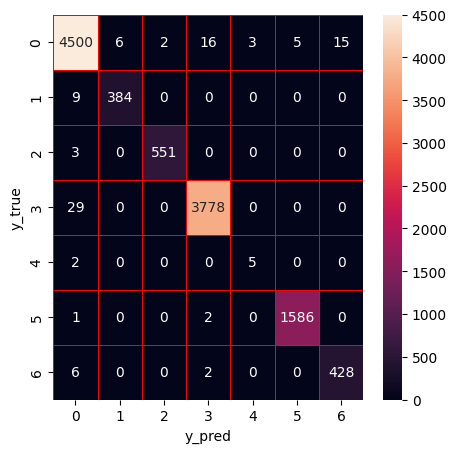

In [257]:
xg = xgb.XGBClassifier(n_estimators = 10)
xg.fit(X_train,y_train)
xg_score=xg.score(X_test,y_test)
y_predict=xg.predict(X_test)
y_true=y_test
print('Accuracy of XGBoost: '+ str(xg_score))
precision,recall,fscore,none= precision_recall_fscore_support(y_true, y_predict, average='weighted')
print('Precision of XGBoost: '+(str(precision)))
print('Recall of XGBoost: '+(str(recall)))
print('F1-score of XGBoost: '+(str(fscore)))
print(classification_report(y_true,y_predict))
cm=confusion_matrix(y_true,y_predict)
f,ax=plt.subplots(figsize=(5,5))
sns.heatmap(cm,annot=True,linewidth=0.5,linecolor="red",fmt=".0f",ax=ax)
plt.xlabel("y_pred")
plt.ylabel("y_true")
plt.show()

In [258]:
xg_train=xg.predict(X_train)
xg_test=xg.predict(X_test)

### Stacking model construction

In [259]:
base_predictions_train = pd.DataFrame( {
    'DecisionTree': dt_train.ravel(),
        'RandomForest': rf_train.ravel(),
     'ExtraTrees': et_train.ravel(),
     'XgBoost': xg_train.ravel(),
    })
base_predictions_train.head(5)

,DecisionTree,RandomForest,ExtraTrees,XgBoost
0,5,5,5,5
1,3,3,3,3
2,5,5,5,5
3,3,3,3,3
4,2,2,2,2


In [260]:
dt_train=dt_train.reshape(-1, 1)
et_train=et_train.reshape(-1, 1)
rf_train=rf_train.reshape(-1, 1)
xg_train=xg_train.reshape(-1, 1)
dt_test=dt_test.reshape(-1, 1)
et_test=et_test.reshape(-1, 1)
rf_test=rf_test.reshape(-1, 1)
xg_test=xg_test.reshape(-1, 1)

In [261]:
x_train = np.concatenate(( dt_train, et_train, rf_train, xg_train), axis=1)
x_test = np.concatenate(( dt_test, et_test, rf_test, xg_test), axis=1)

Accuracy of Stacking: 0.9935586340774729
Precision of Stacking: 0.9939812936975205
Recall of Stacking: 0.9935586340774729
F1-score of Stacking: 0.9937069636410812
              precision    recall  f1-score   support

           0       1.00      0.99      0.99      4547
           1       1.00      0.99      0.99       393
           2       0.96      1.00      0.98       554
           3       1.00      1.00      1.00      3807
           4       0.38      0.71      0.50         7
           5       1.00      1.00      1.00      1589
           6       0.97      0.99      0.98       436

    accuracy                           0.99     11333
   macro avg       0.90      0.95      0.92     11333
weighted avg       0.99      0.99      0.99     11333



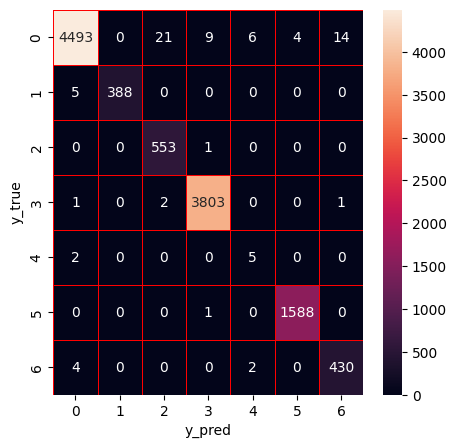

In [262]:
stk = xgb.XGBClassifier().fit(x_train, y_train)
y_predict=stk.predict(x_test)
y_true=y_test
stk_score=accuracy_score(y_true,y_predict)
print('Accuracy of Stacking: '+ str(stk_score))
precision,recall,fscore,none= precision_recall_fscore_support(y_true, y_predict, average='weighted')
print('Precision of Stacking: '+(str(precision)))
print('Recall of Stacking: '+(str(recall)))
print('F1-score of Stacking: '+(str(fscore)))
print(classification_report(y_true,y_predict))
cm=confusion_matrix(y_true,y_predict)
f,ax=plt.subplots(figsize=(5,5))
sns.heatmap(cm,annot=True,linewidth=0.5,linecolor="red",fmt=".0f",ax=ax)
plt.xlabel("y_pred")
plt.ylabel("y_true")
plt.show()

In [263]:
import pickle

# Assuming your model is named 'model'
# and you have trained it already

# Save the model to a .pkl file
with open('xg_model.pkl', 'wb') as f:
    pickle.dump(xg, f)

In [264]:
import pickle

# Assuming your model is named 'model'
# and you have trained it already

# Save the model to a .pkl file
with open('et_model.pkl', 'wb') as f:
    pickle.dump(et, f)


In [265]:
import pickle

# Assuming your model is named 'model'
# and you have trained it already

# Save the model to a .pkl file
with open('rf_model.pkl', 'wb') as f:
    pickle.dump(rf, f)


In [266]:
import pickle

# Assuming your model is named 'model'
# and you have trained it already

# Save the model to a .pkl file
with open('dt_model.pkl', 'wb') as f:
    pickle.dump(dt, f)


In [267]:
with open('xg_model.pkl', 'rb') as f:
    xg_model = pickle.load(f)


with open('et_model.pkl', 'rb') as f:
    et_model = pickle.load(f)

with open('rf_model.pkl', 'rb') as f:
    rf_model = pickle.load(f)

with open('dt_model.pkl', 'rb') as f:
    dt_model = pickle.load(f)

In [268]:
num_features = 15
sample_input = [745402,6,7,991,1424,517,0,165.1666666667,238.80487153040002,1256,0,203.4285714286,1,2,3]
# Reshape the sample input to match the model's expectations
# Convert the sample input to a numpy array
sample_input = np.array(sample_input)
# Reshape the sample input to match the model's expectations
sample_input = sample_input.reshape(1, -1)

In [269]:
xg_prediction = xg_model.predict(sample_input)
et_prediction = et_model.predict(sample_input)
rf_prediction = rf_model.predict(sample_input)
dt_prediction = dt_model.predict(sample_input)

In [270]:
print("XGBoost Prediction:", xg_prediction)

XGBoost Prediction: [5]


In [271]:
print("Extra Trees Prediction:", et_prediction)
print("Random Forest Prediction:", rf_prediction)
print("Decision Tree Prediction:", dt_prediction)

Extra Trees Prediction: [0]
Random Forest Prediction: [0]
Decision Tree Prediction: [0]
